# **Fruits Image Classification using Deep Learning with Pytorch**

In this course project, I will be doing Image Classification on the Fruits 360 dataset from Kaggle (https://www.kaggle.com/moltean/fruits) by building a deep learning model from scratch. This dataset contains a total of nearly 90,000 images of different fruits and vegetables out of which nearly 67,000 are training images and 22,000 are test images. There are 131 different categories of fruits and vegetables which are to be classified. All the images are 100x100 pixel images in .jpg format 

In [2]:
!pip install jovian --upgrade --quiet

Let's begin by installing and importing the required libraries.

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

In [5]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
matplotlib.rcParams['font.size'] = 14

In [6]:
project_name = 'fruits-classification-resnet'

## Downloading the Dataset

In [7]:
from torchvision.datasets.utils import download_url

# Download the Fruits 360 dataset
dataset_url = 'https://www.kaggle.com/moltean/fruits/download'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nikhil1e9
Your Kaggle Key: ··········


  1%|          | 8.00M/760M [00:00<00:09, 81.6MB/s]

100%|██████████| 760M/760M [00:23<00:00, 33.5MB/s]


## Preparing the Dataset

In [8]:
print(os.listdir('.'))

['.config', 'fruits', 'sample_data']


In [9]:
print(os.listdir('./fruits'))

['fruits-360']


In [10]:
# Looking into the Fruits 360 data directory
data_dir = './fruits/fruits-360'
print(os.listdir(data_dir))

['Training', 'test-multiple_fruits', 'readme.md', 'LICENSE', 'Test', 'papers']


In [11]:
classes = os.listdir(data_dir + "/Training")
print(classes)

['Cucumber Ripe', 'Tomato 1', 'Chestnut', 'Apple Pink Lady', 'Raspberry', 'Grape White 3', 'Pepper Yellow', 'Avocado', 'Grape White', 'Pineapple Mini', 'Lemon Meyer', 'Kumquats', 'Grape Blue', 'Tangelo', 'Granadilla', 'Cherry 1', 'Lemon', 'Redcurrant', 'Fig', 'Nectarine Flat', 'Cherry Wax Yellow', 'Pear Monster', 'Pear', 'Guava', 'Watermelon', 'Pitahaya Red', 'Kiwi', 'Apple Crimson Snow', 'Physalis', 'Apple Red Yellow 2', 'Pear Williams', 'Banana Lady Finger', 'Tomato 2', 'Walnut', 'Plum 3', 'Pepper Red', 'Clementine', 'Huckleberry', 'Peach 2', 'Mangostan', 'Grape Pink', 'Hazelnut', 'Cauliflower', 'Apple Red Delicious', 'Cantaloupe 2', 'Physalis with Husk', 'Ginger Root', 'Papaya', 'Grape White 2', 'Potato Sweet', 'Apple Braeburn', 'Lychee', 'Rambutan', 'Tomato Cherry Red', 'Apple Golden 1', 'Cherry Wax Red', 'Cocos', 'Pepper Green', 'Limes', 'Pepper Orange', 'Nut Pecan', 'Apricot', 'Potato Red Washed', 'Potato Red', 'Apple Red 3', 'Mulberry', 'Blueberry', 'Quince', 'Pear Kaiser', 'Koh

In [12]:
num_classes = len(classes)
print(num_classes)

131


As expected there are 131 classes in the training and test datasets.

## Exploring the Data

Let's look inside a couple of folders, one from the training set and another from the test set. 

In [13]:
orange_files = os.listdir(data_dir + "/Training/Orange")
print('No. of training examples for Orange:', len(orange_files))
print(orange_files[:5])

No. of training examples for Orange: 479
['236_100.jpg', '280_100.jpg', 'r_242_100.jpg', 'r_255_100.jpg', '2_100.jpg']


In [14]:
strawberry_files = os.listdir(data_dir + "/Test/Strawberry")
print('No. of test examples for Strawberry:', len(strawberry_files))
print(strawberry_files[:5])

No. of test examples for Strawberry: 164
['94_100.jpg', '77_100.jpg', '66_100.jpg', 'r_90_100.jpg', '47_100.jpg']


By looping through the dataset I found the images belonging to each category as follows:

In [15]:
total_training_images, total_test_images = 0, 0
count = []
for cls in classes:
  training_images = os.listdir(data_dir + '/Training/' + cls)
  test_images = os.listdir(data_dir + '/Test/' + cls)
  img_count = len(training_images)
  count.append(img_count)
  img_count0 = len(test_images)
  print("Number of images belonging to {} is {}".format(cls, img_count, img_count0))
  total_training_images += img_count
  total_test_images += img_count0

Number of images belonging to Cucumber Ripe is 392
Number of images belonging to Tomato 1 is 738
Number of images belonging to Chestnut is 450
Number of images belonging to Apple Pink Lady is 456
Number of images belonging to Raspberry is 490
Number of images belonging to Grape White 3 is 492
Number of images belonging to Pepper Yellow is 666
Number of images belonging to Avocado is 427
Number of images belonging to Grape White is 490
Number of images belonging to Pineapple Mini is 493
Number of images belonging to Lemon Meyer is 490
Number of images belonging to Kumquats is 490
Number of images belonging to Grape Blue is 984
Number of images belonging to Tangelo is 490
Number of images belonging to Granadilla is 490
Number of images belonging to Cherry 1 is 492
Number of images belonging to Lemon is 492
Number of images belonging to Redcurrant is 492
Number of images belonging to Fig is 702
Number of images belonging to Nectarine Flat is 480
Number of images belonging to Cherry Wax Ye

We can see there are roughly 400-500 images belonging to each class.

In [16]:
print("Total number of training images is {}".format(total_training_images))
print("Total number of test images is {}".format(total_test_images))

Total number of training images is 67692
Total number of test images is 22688


I will be using the test set as the validation set for training the model to get better results. Let's group the sets into the respective directories.

In [17]:
data_dir = './fruits/fruits-360'
train_directory = data_dir + '/Training'
val_directory = data_dir + '/Test'

# Data Visualization

Let's visualize the data and get some insight by plotting graphs and looking at some of the images from the dataset.

### Bar Plots

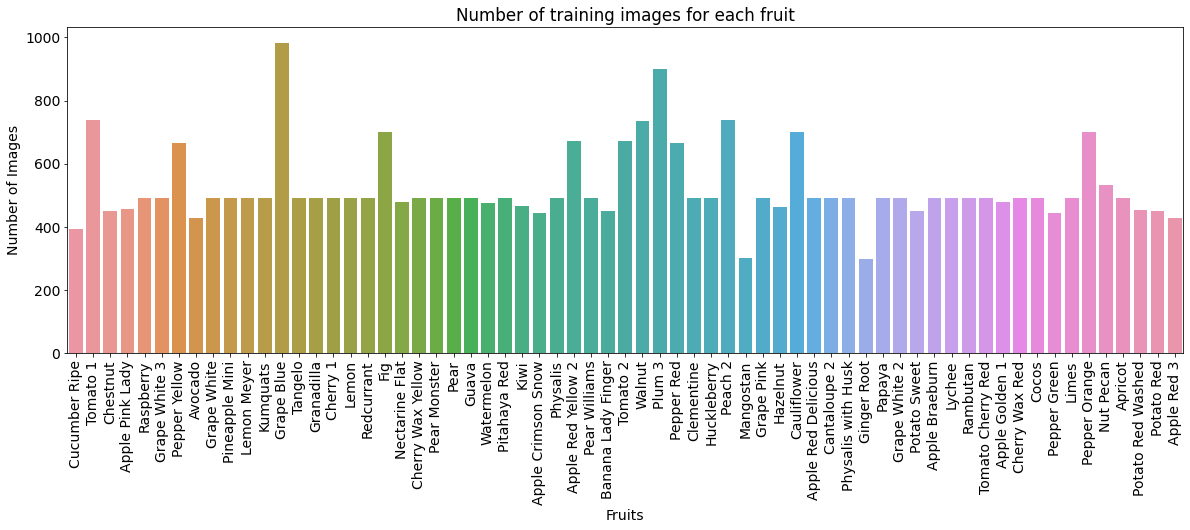

In [18]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x=classes[:65],y=count[:65])
plt.xticks(rotation=90)
plt.xlabel('Fruits')
plt.ylabel('Number of Images')
plt.title('Number of training images for each fruit')

plt.show()

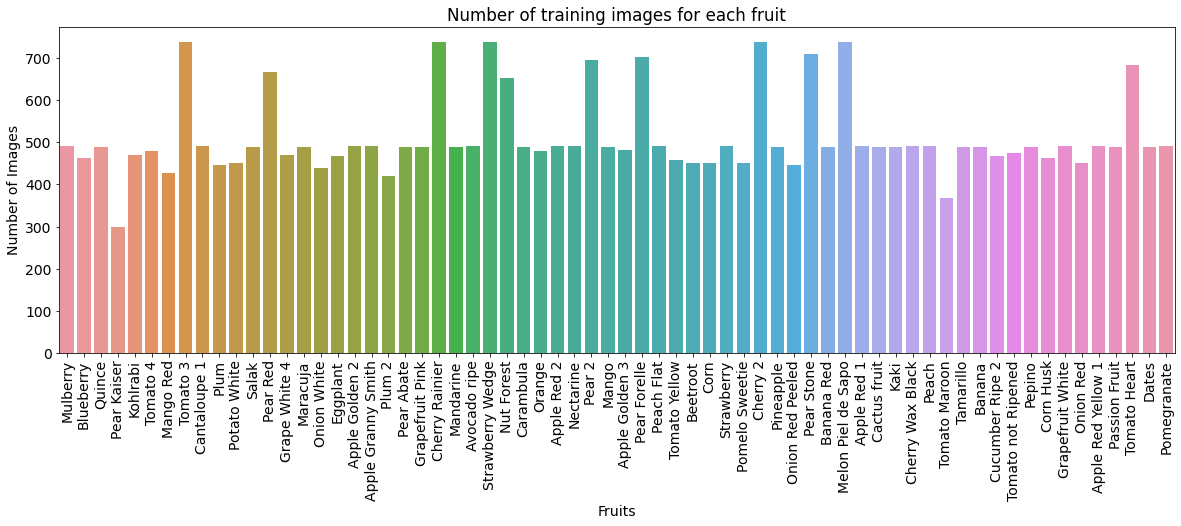

In [19]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x=classes[65:],y=count[65:])
plt.xticks(rotation=90)
plt.xlabel('Fruits')
plt.ylabel('Number of Images')
plt.title('Number of training images for each fruit')

plt.show()

### Looking at Images

In [20]:
dataset = ImageFolder(train_directory, transform=ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 100x100 px color images with 3 channels (RGB), each image tensor has the shape (3, 100, 100).

In [21]:
img, label = dataset[0]
print('img_shape:', img.shape)
print('Label:', label)
img

img_shape: torch.Size([3, 100, 100])
Label: 0


tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [22]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Apple Braeburn (0)


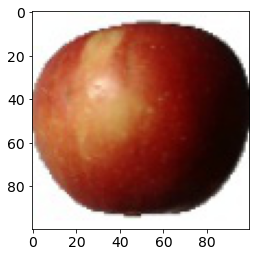

In [23]:
show_example(*dataset[0])

Label:  Lemon (59)


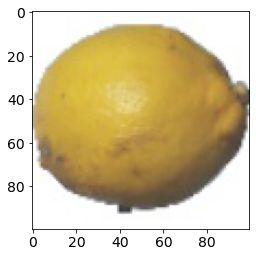

In [24]:
show_example(*dataset[30000])

Label:  Raspberry (113)


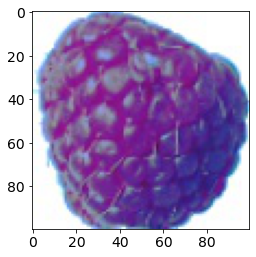

In [25]:
show_example(*dataset[57897])

Let's create a sample dataloader with a batch size of 64

In [26]:
data_loader = DataLoader(dataset, 64)

Next I will create a function for calculating the means and standard deviations from the data loader which will be used later for normalization of the data.

In [27]:
def get_mean_sd(loader):
  channel_sum, channel_squared_sum, num_batches = 0, 0, 0
  for image, _ in loader:
    channel_sum += torch.mean(image, dim=[0,2,3])
    channel_squared_sum += torch.mean(image**2, dim=[0,2,3])
    num_batches += 1
  
  mean = channel_sum / num_batches
  sd = (channel_squared_sum / num_batches - mean**2)**0.5

  return mean, sd

In [28]:
mean, sd = get_mean_sd(data_loader)
print(mean)
print(sd)

tensor([0.6840, 0.5786, 0.5037])
tensor([0.3035, 0.3600, 0.3914])


## Data Augmentation and Normalization

In [29]:
image_size = 32

In [113]:
# Data transforms (normalization & data augmentation)
stats = ((0.6840, 0.5786, 0.5037), (0.3035, 0.3600, 0.3914))
train_tfms = tt.Compose([tt.Resize((image_size, image_size)),
                         tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()])
                         #,tt.Normalize(*stats,inplace=True)])
val_tfms = tt.Compose([tt.Resize((image_size, image_size)),
                       tt.ToTensor()])
                       #,tt.Normalize(*stats)])

Creating training and validation datasets using the ImageFolder class from torchvision and also plugging in the transforms.

In [114]:
train_ds = ImageFolder(train_directory, train_tfms)
val_ds = ImageFolder(val_directory, val_tfms)

Next, I will create data loaders for retrieving images in batches. I will use a batch size of 128. This can be changed depending on the training time of the model.

In [32]:
batch_size = 128
# batch_size = 400

In [115]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, I will need to denormalize the pixels values to bring them back into the range (0,1).

In [116]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        #denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

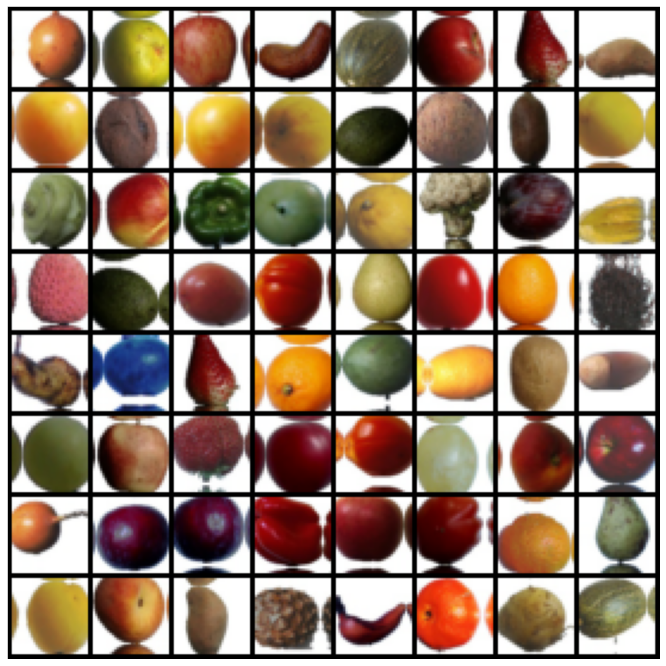

In [117]:
show_batch(train_loader)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, I define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move my model & data to the GPU as required.

In [118]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [119]:
device = get_default_device()
device

device(type='cuda')

I now wrap the training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU.

In [120]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [123]:
for img, _ in train_loader:
  print(img.shape)
  break

torch.Size([128, 3, 32, 32])


After resizing the images the images now become 32x32 px images.

## Model using the Resnet9 architecture

In [40]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FruitsImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

I develop the ResNet9 model through extending the ImageClassificationBase class. The conv_block function uses Convolutional Neural Network layers which is the building block for the resnet9 architecture. Also, after each convolutional layer, I add a batch normalization layer, which normalizes the outputs of the previous layer.
Addition of the Residual block also produces a significant improvement in the performance of the model.

In [124]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class FruitsResNet9(FruitsImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)    # output: 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)   # output: 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)   # output: 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),    # output: 512 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [125]:
model = to_device(FruitsResNet9(3, 131), device)
model;

## Training the model

In [126]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before I begin training, I evaluate the instantiated model in order to see how it performs on the validation set with the initial set of parameters.



In [127]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.007198033854365349, 'val_loss': 4.875837802886963}]

The model is now ready to be trained. Instead of SGD (stochastic gradient descent), I will use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training.

In [46]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [128]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 0.7080, val_loss: 0.6342, val_acc: 0.8078
Epoch [1], last_lr: 0.00760, train_loss: 0.2594, val_loss: 1.1496, val_acc: 0.7646
Epoch [2], last_lr: 0.01000, train_loss: 0.1299, val_loss: 0.5139, val_acc: 0.8380
Epoch [3], last_lr: 0.00950, train_loss: 0.0948, val_loss: 0.2560, val_acc: 0.9258
Epoch [4], last_lr: 0.00812, train_loss: 0.0762, val_loss: 0.1634, val_acc: 0.9539
Epoch [5], last_lr: 0.00611, train_loss: 0.0500, val_loss: 0.1072, val_acc: 0.9620
Epoch [6], last_lr: 0.00389, train_loss: 0.0363, val_loss: 0.0659, val_acc: 0.9839
Epoch [7], last_lr: 0.00188, train_loss: 0.0142, val_loss: 0.0253, val_acc: 0.9936
Epoch [8], last_lr: 0.00050, train_loss: 0.0030, val_loss: 0.0211, val_acc: 0.9964
Epoch [9], last_lr: 0.00000, train_loss: 0.0010, val_loss: 0.0205, val_acc: 0.9967
CPU times: user 1min 55s, sys: 16.2 s, total: 2min 11s
Wall time: 9min 58s


In [129]:
train_time = '9:58'

In [130]:
result = evaluate(model, val_loader)
result

{'val_acc': 0.9967082142829895, 'val_loss': 0.020510613918304443}

My model achieves accuracy of nearly a 100%. This surprised me too. This is because of using the test set as the validation set as it gave my model a large number of images to train from. In addition I used various Data transformation and augmentation techniques to generalize the data. Also during training I chose the best set of hyperparameters for the model after training the model various times using different sets of hyperparameters.

## Model Accuracy and Loss Plots

Let's plot the valdation set accuracies to study how the model improves over time.

In [131]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.set_style('darkgrid')

In [132]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

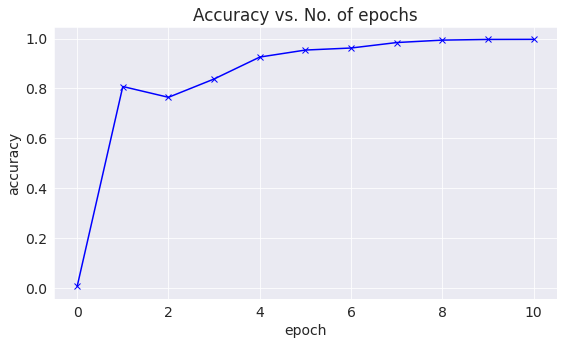

In [133]:
plot_accuracies(history)

Plotting the training and validation losses to study the trend.

In [134]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

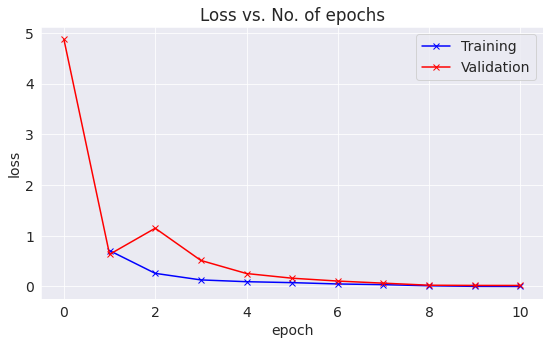

In [135]:
plot_losses(history)

As seen above the validation losses and the training losses follow the same trend and also no overfitting can be seen from the validation loss.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [136]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs, 'b') 
    plt.xlabel('Batch No.')
    plt.ylabel('One Cycle Learning Rate Scheduler')
    plt.title('One Cycle Learning Rate Scheduler vs. Batch No.');

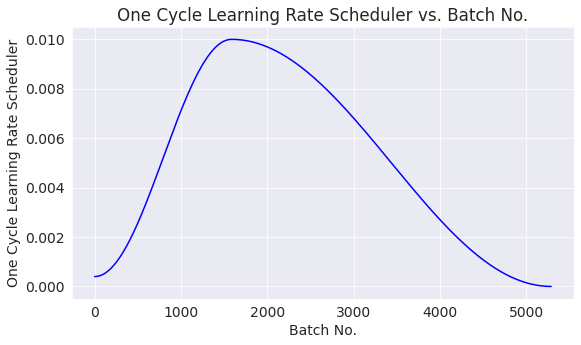

In [137]:
plot_lrs(history)

## Testing with individual images

In [180]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Apple Braeburn , Predicted: Apple Braeburn


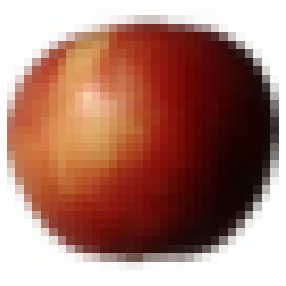

In [181]:
img, label = val_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Lemon , Predicted: Lemon


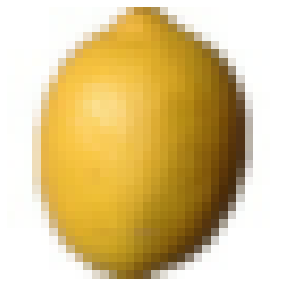

In [182]:
img, label = val_ds[9951]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Plum , Predicted: Plum


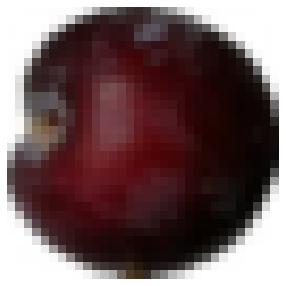

In [183]:
img, label = val_ds[17644]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Mango , Predicted: Mango


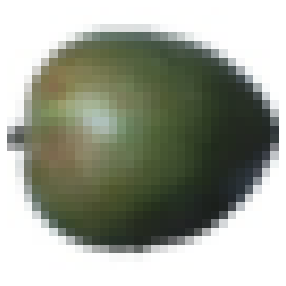

In [184]:
img, label = val_ds[10865]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Watermelon , Predicted: Watermelon


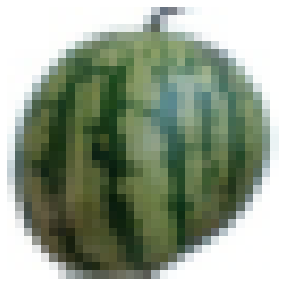

In [185]:
img, label = val_ds[22578]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Orange , Predicted: Orange


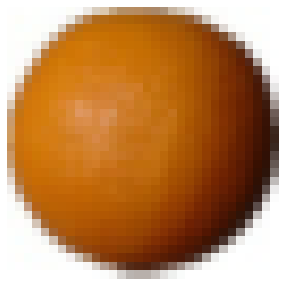

In [186]:
img, label = val_ds[12999]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Tamarillo , Predicted: Tamarillo


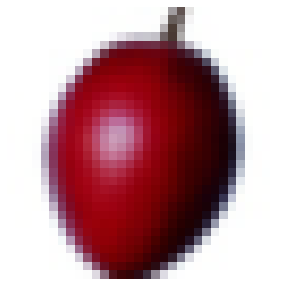

In [187]:
img, label = val_ds[20320]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Strawberry , Predicted: Strawberry


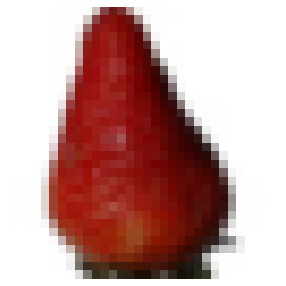

In [188]:
img, label = val_ds[19876]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Banana , Predicted: Banana


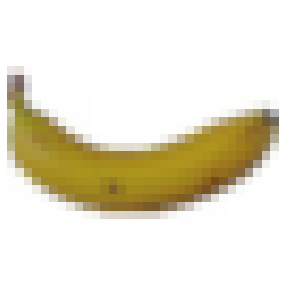

In [189]:
img, label = val_ds[2688]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Tomato 3 , Predicted: Tomato 3


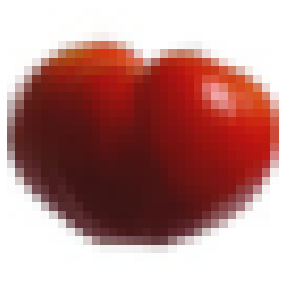

In [179]:
img, label = val_ds[21098]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

## Save and Commit

Let's save the weights of the model, record the hyperparameters, and save all the progress. It helps to keep the recorded data in a systematic way so that it can be easily reviewed later to make changes in the model and also makes it a lot easier to study and analyze the model.

In [106]:
torch.save(model.state_dict(), 'fruits-resnet9.pth')

In [107]:
!pip install jovian --upgrade --quiet

In [108]:
import jovian

In [109]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9',
                       batch_size=batch_size,
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [110]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [111]:
jovian.commit(project=project_name, environment=None, outputs=['fruits-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/nikhil/fruits-classification-resnet


'https://jovian.ai/nikhil/fruits-classification-resnet'

## Summary of the Employed Techniques

Here's a summary of the different techniques used in this Deep Learning Model to improve the model performance and reduce the training time:

**Using test set for validation:** Instead of setting aside a fraction of the data from the training set for validation, I simply used the test set as my validation set. This just gives a little more data to train with and helps the model to generalize better. 

**Channel-wise data normalization:** I normalized the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values than others.

**Randomized data augmentations:** I applied randomly chosen transformations while loading images from the training dataset. Specifically, I padded each image by 4 pixels, and then took a random crop of size 32 x 32 pixels, and then flipped the image horizontally with a 50% probability. Since the transformation is applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

**Residual Connections:** One of the key area of improvements to my ResNet9 model was the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

**Batch Normalization:** After each convolutional layer, I added a Batch Normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to Data Normalization, except it is applied to the outputs of a layer, and the mean and standard deviation are learned parameters.

**Learning Rate Scheduling:** Instead of using a fixed learning rate, I used a Learning Rate Scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and I used the "One Cycle Learning Rate Policy". In this the learning rate starts at a low value and gradually increases for 30% of the epochs to or close to a defined maximum value, followed by gradually decreasing to a very small value for the rest of the epochs.

**Weight Decay:** I added Weight Decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

**Gradient Clipping:** Moreover, I added Gradient Clipping capability, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters owing to large gradient values during training.

**Adam Optimizer:** Instead of SGD (Stochastic Gradient Descent), I used the Adam optimizer which uses techniques such as momentum and adaptive learning rates for faster training.

## References and future work

* **Data Normalization:** https://medium.com/@ml_kid/
what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd

* **Data Augmentation:** https://jovian.ai/outlink?url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2019%2F12%2Fimage-augmentation-deep-learning-pytorch%2F

* **Resnet:** https://myrtle.ai/learn/how-to-train-your-resnet/

* **Residual Connections:** https://jovian.ai/outlink?url=https%3A%2F%2Ftowardsdatascience.com%2Fresidual-blocks-building-blocks-of-resnet-fd90ca15d6ec

* **Batch Normalization:** https://jovian.ai/outlink?url=https%3A%2F%2Ftowardsdatascience.com%2Fbatch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

* **Learning Rate Scheduling:** https://jovian.ai/outlink?url=https%3A%2F%2Fsgugger.github.io%2Fthe-1cycle-policy.html

* **Weight Decay:** https://jovian.ai/outlink?url=https%3A%2F%2Ftowardsdatascience.com%2Fthis-thing-called-weight-decay-a7cd4bcfccab

* **Gradient Clipping:** https://jovian.ai/outlink?url=https%3A%2F%2Ftowardsdatascience.com%2Fwhat-is-gradient-clipping-b8e815cdfb48%2363e0

* **Adam Optimizer:** https://jovian.ai/outlink?url=https%3A%2F%2Fruder.io%2Foptimizing-gradient-descent%2Findex.html


As future work, I can try applying each technique independently and see how much each one affects the performance and training time. As I try different experiments, I will eventually grow the intuition for picking the right architectures, regularization techniques and hyperparameters.